#Import Libraries

In [ ]:
!pip install captum
!pip install sewar

In [ ]:
import torch
import torch.nn.functional as F
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import pickle
import glob
import random
from scipy import ndimage
from PIL import Image
import zipfile
import pandas as pd
from matplotlib import cm
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import math
from numpy import asarray
from prettytable import PrettyTable 
from itertools import combinations

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, precision_recall_curve

from captum.attr import GuidedGradCam
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import LRP 

from sewar.full_ref import msssim
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# choose path to save models and explanations
my_path = '/content/gdrive/MyDrive/Paper_XAI/final_code&files/'
explanation_path = my_path + 'explanations/'

# create directories for each type of visual explanation
methods = ['Saliency_Maps/', 'Integrated Gradients/', 'LRP/', 'Deep_Lift/']
grids = ['4x4/', '8x8/', '16x16/', '80x80/']
save=False
if save==True:
  os.mkdir(explanation_path)
  for method in methods:
    os.mkdir(explanation_path+method)
    for grid in grids:
      os.mkdir(explanation_path+method+grid)

# Architecture

In [ ]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 192, kernel_size=3, stride=1,padding=1)
        self.conv4 = nn.Conv2d(192, 256, kernel_size=3, stride=1, padding=1)
        
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.bn3 = nn.BatchNorm2d(num_features=192)
        self.bn4 = nn.BatchNorm2d(num_features=256)
                
    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))             
        x = self.mp1(x)
        x = self.relu2(self.bn2(self.conv2(x)))    
        x = self.mp2(x)      
        x = self.relu3(self.bn3(self.conv3(x)))   
        x = self.mp3(x)      
        x = self.relu4(self.bn4(self.conv4(x)))
        return x

class classifier(nn.Module):
    def __init__(self, hidden_neurons, hidden_layers, feature_size, drop):
        super(classifier, self).__init__()
        
        num_classes = 2
        self.hidden_layers = hidden_layers
        
        self.dropout = nn.Dropout(drop, False)

        self.features_in = 256*10**2     
        self.fc = nn.Linear(self.features_in, num_classes, True)

    def forward(self, x):
        batch_size = x.shape[0]        
        x = x.view(batch_size, self.features_in)
        x = self.dropout(x)
        x = self.fc(x)  
        return x

class nodule_classifier(nn.Module):
    def __init__(self, hidden_neurons, hidden_layers, feature_size, drop):
        super(nodule_classifier, self).__init__()
        
        self.encoder = encoder()
        self.classifier = classifier(hidden_neurons, hidden_layers, feature_size, drop)
        self.gradients = None

    def forward(self, x):        
        x = self.encoder(x)           
        x = self.classifier(x)          
        return x

#Dataset

In [ ]:
def normalizePlanes(npzarray,maxHU = 400.,minHU = -1000.):
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray > 1] = 1
    npzarray[npzarray < 0] = 0
    return npzarray

class malignancy_dataset():
    def __init__(self, b_paths, m_paths, train, test, mask_dicts):
        #train and test are bools indicating the function of the fold
        self.b_paths, self.m_paths = b_paths, m_paths
        self.train, self.test = train, test
        
        b_labels = [0 for _ in range(len(self.b_paths))]
        m_labels = [1 for _ in range(len(self.m_paths))]
        
        self.all_nodules = self.b_paths + self.m_paths
        self.all_labels = b_labels + m_labels

        self.mask_dicts = mask_dicts

      
    def __getitem__(self, index):

        def crop(img):
            return np.float64(img)
        
        y = self.all_labels[index]
        new_y = torch.from_numpy(np.asarray(y))
        
        diag = np.arange(80)
        diag2 = -diag + 79        

        try:
            found, count = False, 0
            for elem in self.mask_dicts:
                if elem['patient'] == self.all_nodules[index].split('/')[3]:
                    if elem['nodule'] == self.all_nodules[index].split('/')[4]:
                        ind_bigger_1 = elem['index_1']
                        ind_bigger_2 = elem['index_2']
                        ind_bigger_3 = elem['index_3']
                        found = True
                        break
                count += 1
                if not found and count == len(self.mask_dicts):
                    print('Error! ind_bigger not found!!')
        except:
            pass

        if self.train:
            if y == 1:
                transf_list = [1, 2, 3, 4, 5, 6, 7]
            else:
                transf_list = [1, 2, 3, 4, 5, 6]
        elif self.test:
            transf_list = [2]
        transf = random.sample(list(transf_list), 1)[0]
         
        if transf == 1:
            pre_x = crop(np.load(self.all_nodules[index])[:, ind_bigger_2, :])
            x = normalizePlanes(pre_x)
        elif transf == 2:
            pre_x = crop(np.load(self.all_nodules[index])[ind_bigger_1, :, :])
            x = normalizePlanes(pre_x)
        elif transf == 3:
            pre_x = crop(np.load(self.all_nodules[index])[:, :, ind_bigger_3])
            x = normalizePlanes(pre_x)              
        elif transf == 4:
            transf_flip = random.sample([1, 2, 3], 1)[0]
            if transf_flip == 1:
                pre_x = crop(np.load(self.all_nodules[index])[ind_bigger_1, :, :])
            elif transf_flip == 2:
                pre_x = crop(np.load(self.all_nodules[index])[:, ind_bigger_2, :])
            elif transf_flip == 3:
                pre_x = crop(np.load(self.all_nodules[index])[:, :, ind_bigger_3])         
            x = normalizePlanes(np.flip(pre_x, axis = 0).copy())
        elif transf == 5:
            transf_flip = random.sample([1, 2, 3], 1)[0]
            if transf_flip == 1:
                pre_x = crop(np.load(self.all_nodules[index])[ind_bigger_1, :, :])
            elif transf_flip == 2:
                pre_x = crop(np.load(self.all_nodules[index])[:, ind_bigger_2, :])
            elif transf_flip == 3:
                pre_x = crop(np.load(self.all_nodules[index])[:, :, ind_bigger_3])
            x = normalizePlanes(np.flip(pre_x, axis = 1).copy())
        elif transf == 6:
            ang = random.sample(list([-15, -10, -5, 5, 10, 15]), 1)[0]
            transf_rot = random.sample([1, 2, 3], 1)[0]
            if transf_rot == 1:
                pre_x = crop(np.load(self.all_nodules[index])[ind_bigger_1, :, :])
            elif transf_rot == 2:
                pre_x = crop(np.load(self.all_nodules[index])[:, ind_bigger_2, :])
            elif transf_rot == 3:
                pre_x = crop(np.load(self.all_nodules[index])[:, :, ind_bigger_3])
            x = normalizePlanes(ndimage.rotate(pre_x, ang, reshape = False))

        elif transf == 7:
            pre_x = crop(np.load(self.all_nodules[index])[diag, diag, :])
            x = normalizePlanes(pre_x)
        elif transf == 8:
            pre_x = crop(np.load(self.all_nodules[index])[diag, :, diag])
            x = normalizePlanes(pre_x)
        elif transf == 9:
            pre_x = crop(np.load(self.all_nodules[index])[:, diag, diag])
            x = normalizePlanes(pre_x)
        elif transf == 10:
            pre_x = crop(np.load(self.all_nodules[index])[:, diag, diag2])
            x = normalizePlanes(pre_x)        

        new_x = torch.from_numpy(x).repeat(1,1,1)

        return new_x, new_y, self.all_nodules[index]
    
    def __len__(self):
        return len(self.all_nodules)

In [ ]:
def get_data():

    if not os.path.isdir('/content/cropped_ct'):
        with zipfile.ZipFile('/content/gdrive/MyDrive/Paper_XAI/cropped_ct.zip', 'r') as zip_ref:
            zip_ref.extractall('/content')
    table = pd.read_csv('/content/gdrive/MyDrive/Paper_XAI/final-lidc-scores-grouped.csv')

    keys = ['patient_id', 'nodule_id']
    benign_list = []
    malignant_list = []
    no_benign = 0
    no_malignant = 0

    for i in range(len(table)):
      to_add = {key: None for key in keys}

      if table.loc[i, 'mean'] <= 2:
        no_benign += 1
        to_add['patient_id'] = table.loc[i, 'patient_id']
        to_add['nodule_id'] = table.loc[i, 'nodule_id']
        benign_list.append(to_add)

      elif table.loc[i, 'mean'] >= 4:
        no_malignant += 1
        to_add['patient_id'] = table.loc[i, 'patient_id']
        to_add['nodule_id'] = table.loc[i, 'nodule_id']
        malignant_list.append(to_add)

    print('---- initial list sizes ----')
    print(no_benign, no_malignant)
    print(len(benign_list), len(malignant_list), '\n')
    print('benign list: ', benign_list,'\n')
    print('malignant list: ', malignant_list,'\n')

    final_benign_list = []
    final_malignant_list = []

    for item in benign_list:
      try:
        print(item['patient_id'].split('_')[1], item['patient_id'])
        if item['patient_id'].split('_')[1] == '1':
            print('(benign)...removing entry: {}\t' .format(item))
        else:
            final_benign_list.append(item)
      except:
        final_benign_list.append(item)

    for item in malignant_list:
      try:
        print(item['patient_id'].split('_')[1], item['patient_id'])
        if item['patient_id'].split('_')[1] == '1':
            print('(malignant)...removing entry: {}\t' .format(item))
        else:
            final_malignant_list.append(item)
      except:
        final_malignant_list.append(item)

    training_benign = []
    training_malignant = []
    for patient in os.listdir('/content/cropped_ct'):
        for j in range(len(final_benign_list)):
            if patient == final_benign_list[j]['patient_id']:
                nodules = os.listdir('/content/cropped_ct/' + patient)
                for nodule in nodules:
                    if int(nodule.split('.')[0].split('_')[1]) + 1 == final_benign_list[j]['nodule_id']:                            
                        training_benign.append('/content/cropped_ct/' + patient + '/' + nodule)

    print(len(training_benign))
    print(training_benign)

    for patient in os.listdir('/content/cropped_ct'):
        for j in range(len(final_malignant_list)):
            if patient == final_malignant_list[j]['patient_id']:
                nodules = os.listdir('/content/cropped_ct/' + patient)
                for nodule in nodules:
                    if int(nodule.split('.')[0].split('_')[1]) + 1 == final_malignant_list[j]['nodule_id']:                            
                        training_malignant.append('/content/cropped_ct/' + patient + '/' + nodule)

    print(len(training_malignant))
    print(training_malignant)

    print('\nLoading list with bigger mask indexes...')
    infile = open('/content/gdrive/MyDrive/Paper_XAI/mask_idx.pkl', 'rb')
    mask_dicts = pickle.load(infile)
    infile.close()
    print('... number of elements in dictionary: ', len(mask_dicts))

    return training_benign, training_malignant, mask_dicts

In [ ]:
def get_data_split():
    
    training_benign, training_malignant, mask_dicts = get_data()
    print(len(training_benign), len(training_malignant))

    no_b_test = 70
    no_m_test = 30

    no_b_val = 152
    no_m_val = 68

    test_benign = []
    test_malignant = []

    val_benign = []
    val_malignant = []

    while len(test_benign) < no_b_test:
        r = random.sample(training_benign, 1)[0]
        if r not in test_benign:
            test_benign.append(r)
            training_benign.remove(r)
    while len(test_malignant) < no_m_test:
        r = random.sample(training_malignant, 1)[0]
        if r not in test_malignant:
            test_malignant.append(r)
            training_malignant.remove(r)

    while len(val_benign) < no_b_val:
        r = random.sample(training_benign, 1)[0]
        if r not in val_benign:
            val_benign.append(r)
            training_benign.remove(r)
    while len(val_malignant) < no_m_val:
        r = random.sample(training_malignant, 1)[0]
        if r not in val_malignant:
            val_malignant.append(r)
            training_malignant.remove(r)

      
    print('Malignant Nodules: Training => {} - Validation => {} - Testing => {}\t' 
          .format(len(training_malignant), len(val_malignant), len(test_malignant)))
    print('Benign Nodules: Training => {} - Validation => {} - Testing => {}\t' 
          .format(len(training_benign), len(val_benign), len(test_benign)))
    print()

    for example in test_benign:
        if example in val_benign or example in training_benign:
            print('WARNING!!!')
    for example in test_malignant:
        if example in val_malignant or example in training_malignant:
            print('WARNING!!!')

    return training_malignant, val_malignant, test_malignant, training_benign, val_benign, test_benign, mask_dicts

#Train and Save Models

In [ ]:
training_malignant, val_malignant, test_malignant, training_benign, val_benign, test_benign, mask_dicts = get_data_split()

In [ ]:
def train_model(model, criterion, num_epochs, optimizer, to_check):
    since = time.time()
    train_hist = []
    valid_hist = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    wts_epoch = 0

    to_check_flag = False

    for epoch in range(num_epochs):                  
        
        for param_group in optimizer.param_groups:
            actual_lr = param_group['lr']
        if epoch % 10 == 0 and epoch > 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = actual_lr*0.9
        
        if epoch % 25 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        model.train()
        all_train_paths = []
        for inputs, labels, path in trainloader:

            if to_check_flag:
                if to_check in path:
                    index = path.index(to_check)
                else:
                    index = None

            inputs = inputs.to(DEVICE, dtype = torch.float) 
            labels = labels.to(DEVICE, dtype = torch.long)

            with torch.set_grad_enabled(True):
                outputs = model(inputs) # forward pass
                loss = criterion(outputs, labels)
            
                if to_check_flag and epoch % 5 == 0:
                    if index != None:
                        output_check = outputs[index]
                        grad_cam = GradCam(model)
                        cam, prediction = grad_cam.generate_cam(inputs[index].repeat(1,1,1,1), labels[index])
                        heatmap, heatmap_on_image = apply_colormap_on_image(inputs[index].cpu().numpy().squeeze(), cam)
                        plot_images(inputs[index].cpu().numpy().squeeze(), cam, heatmap_on_image)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        model.eval()
        with torch.no_grad():                    
            train_loss = 0.
            for i, (inputs, labels, path) in enumerate(trainloader):
                inputs = inputs.to(DEVICE, dtype = torch.float) 
                labels = labels.to(DEVICE, dtype = torch.long)                
                outputs = model(inputs) # forward pass
                train_loss += criterion(outputs, labels)
            
            train_loss /= (i + 1)
            train_hist.append(train_loss.item()) #train_loss compute
            if epoch % 25 == 0:
                print('....train loss: {:.3f}'.format(train_loss.item()))

            if validloader is None:
                print()
                continue
            
            valid_loss = 0.
            for i, (inputs, labels, path) in enumerate(validloader):
                inputs = inputs.to(DEVICE, dtype = torch.float) 
                labels = labels.to(DEVICE, dtype = torch.long)
                outputs = model(inputs) 
                valid_loss += criterion(outputs, labels)
            valid_loss /= (i + 1)
            valid_hist.append(valid_loss.item())
            if epoch % 25 == 0:
                print('....valid loss: {:.3f}'.format(valid_loss.item()))
                print()
            
            if valid_loss.item() <= best_loss:
                best_loss = valid_loss.item()
                best_model_wts = copy.deepcopy(model.state_dict())
                wts_epoch = epoch

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    print('Best model weights achieved on epoch {}'.format(wts_epoch))
    model.load_state_dict(best_model_wts)

    return model, train_hist, valid_hist

--------------------------------------------------
RUN 0/10
--------------------------------------------------
---- initial list sizes ----
787 306
787 306 

benign list:  [{'patient_id': 'LIDC-IDRI-0535', 'nodule_id': 4}, {'patient_id': 'LIDC-IDRI-0535', 'nodule_id': 6}, {'patient_id': 'LIDC-IDRI-0557', 'nodule_id': 1}, {'patient_id': 'LIDC-IDRI-0268', 'nodule_id': 1}, {'patient_id': 'LIDC-IDRI-1008', 'nodule_id': 3}, {'patient_id': 'LIDC-IDRI-1008', 'nodule_id': 4}, {'patient_id': 'LIDC-IDRI-1008', 'nodule_id': 6}, {'patient_id': 'LIDC-IDRI-0788', 'nodule_id': 2}, {'patient_id': 'LIDC-IDRI-0999', 'nodule_id': 4}, {'patient_id': 'LIDC-IDRI-0267', 'nodule_id': 2}, {'patient_id': 'LIDC-IDRI-0297', 'nodule_id': 1}, {'patient_id': 'LIDC-IDRI-0126', 'nodule_id': 1}, {'patient_id': 'LIDC-IDRI-0470', 'nodule_id': 1}, {'patient_id': 'LIDC-IDRI-0426', 'nodule_id': 1}, {'patient_id': 'LIDC-IDRI-0042', 'nodule_id': 6}, {'patient_id': 'LIDC-IDRI-0477', 'nodule_id': 1}, {'patient_id': 'LIDC-IDRI-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


TP: 16	
TN: 66	
FP: 4	
FN: 14	
              precision    recall  f1-score   support

      benign       0.82      0.94      0.88        70
   malignant       0.80      0.53      0.64        30

    accuracy                           0.82       100
   macro avg       0.81      0.74      0.76       100
weighted avg       0.82      0.82      0.81       100



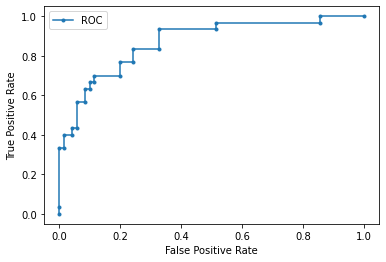

AUC value on test set: 0.869/0.869	
F-score on test set: 0.640	


['/content/cropped_ct/LIDC-IDRI-0856/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0493/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_04.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_05.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_07.npy', '/content/cropped_ct/LIDC-IDRI-0318/nodule_00.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


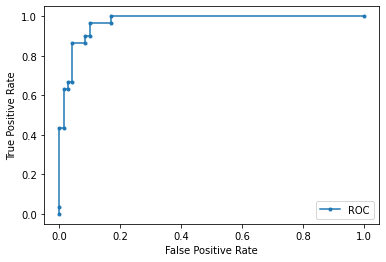

AUC value on test set: 0.972/0.972	
F-score on test set: 0.862	


['/content/cropped_ct/LIDC-IDRI-0856/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0022/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0638/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_03.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


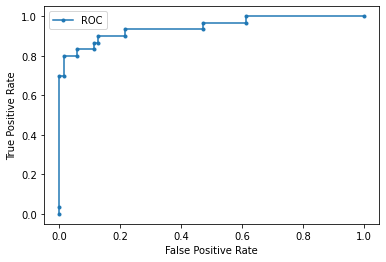

AUC value on test set: 0.945/0.945	
F-score on test set: 0.873	


['/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0022/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0493/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_04.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_05.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_06.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_07.npy', '/content/cropped_ct/LIDC-IDRI-0267/nodule_01.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


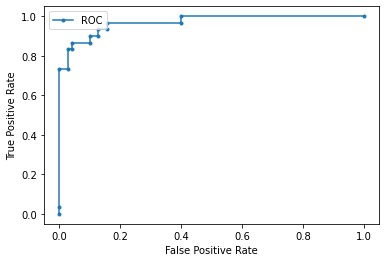

AUC value on test set: 0.970/0.970	
F-score on test set: 0.877	


['/content/cropped_ct/LIDC-IDRI-0856/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0022/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0638/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0493/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_04.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_06.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_07.npy', '/content/cropped_ct/LIDC-IDRI-0499/nodule_01.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


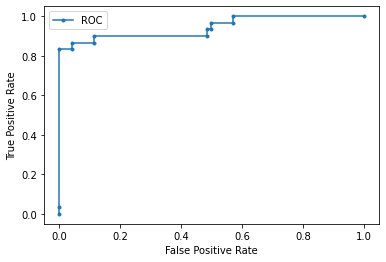

AUC value on test set: 0.943/0.943	
F-score on test set: 0.893	


['/content/cropped_ct/LIDC-IDRI-0856/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0638/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0493/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_04.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_05.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_06.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


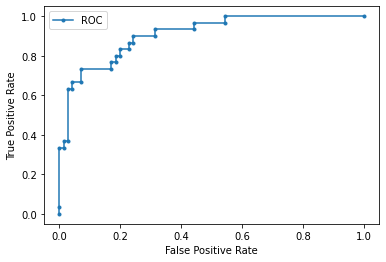

AUC value on test set: 0.908/0.908	
F-score on test set: 0.750	


['/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0022/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0638/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_05.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_07.npy', '/content/cropped_ct/LIDC-IDRI-0267/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0318/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0321/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0321/nodule_02.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


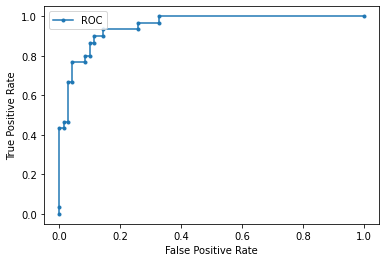

AUC value on test set: 0.952/0.952	
F-score on test set: 0.800	


['/content/cropped_ct/LIDC-IDRI-0856/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_04.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_05.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_07.npy', '/content/cropped_ct/LIDC-IDRI-0318/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0321/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0321/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0321/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0940/nodule_01.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


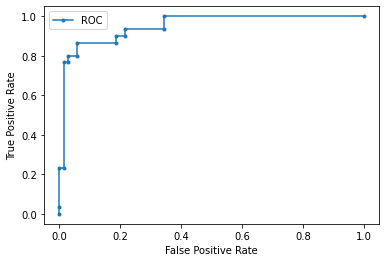

AUC value on test set: 0.951/0.951	
F-score on test set: 0.852	


['/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0638/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_04.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_07.npy', '/content/cropped_ct/LIDC-IDRI-0499/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0267/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0318/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0793/nodule_00.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


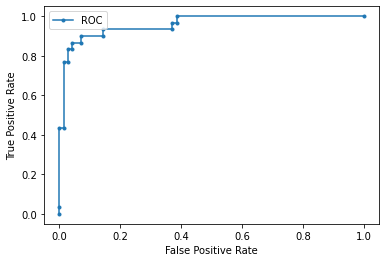

AUC value on test set: 0.960/0.960	
F-score on test set: 0.877	


['/content/cropped_ct/LIDC-IDRI-0856/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0022/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0624/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0638/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0493/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0588/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_03.npy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


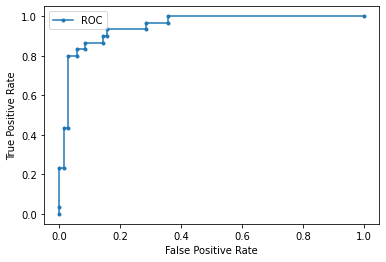

AUC value on test set: 0.950/0.950	
F-score on test set: 0.836	


['/content/cropped_ct/LIDC-IDRI-0856/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0997/nodule_03.npy', '/content/cropped_ct/LIDC-IDRI-0652/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0747/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0638/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0823/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0493/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0372/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0976/nodule_02.npy', '/content/cropped_ct/LIDC-IDRI-0411/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0069/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_05.npy', '/content/cropped_ct/LIDC-IDRI-0748/nodule_06.npy', '/content/cropped_ct/LIDC-IDRI-0267/nodule_01.npy', '/content/cropped_ct/LIDC-IDRI-0318/nodule_00.npy', '/content/cropped_ct/LIDC-IDRI-0793/nodule_00.npy

In [ ]:
n_runs = 10 # define no. of models to generate

for n in range(n_runs):
    print('-' * 50)
    print('RUN {}/{}'.format(n, n_runs))
    print('-' * 50)      

    training_malignant, val_malignant, test_malignant, training_benign, val_benign, test_benign, mask_dicts = get_data_split()
    
    to_check = '/content/cropped_ct/LIDC-IDRI-0001/nodule_00.npy'
    print(to_check)

    if to_check in training_malignant or to_check not in training_malignant:

        train_dataset = malignancy_dataset(training_benign, training_malignant, True, False, mask_dicts)
        val_dataset = malignancy_dataset(val_benign, val_malignant, False, True, mask_dicts)
        test_dataset = malignancy_dataset(test_benign, test_malignant, False, True, mask_dicts)
        
        # save test samples to use later for congruence assessment
        np.save(my_path + 'test_samples/test_b' + str(n) + '.npy', test_benign)
        np.save(my_path + 'test_samples/test_m' + str(n) + '.npy', test_malignant)
        np.save(my_path + 'mask_dicts/mask_dicts' + str(n) + '.npy', mask_dicts)

        hidden_neurons = 64
        hidden_layers = 0
        feature_size = 8
        drop = 0.5
        wd = 1e-2
        batch_size = 128
        lr = 0.0003
        num_epochs = 75        
        criterion = nn.CrossEntropyLoss()

        model = nodule_classifier(hidden_neurons, hidden_layers, feature_size, drop)
        model = model.to(DEVICE, dtype=torch.float)        

        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad is True:
                params_to_update.append(param)
                print('\t', name)

        optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr, momentum = 0.9, weight_decay = wd)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)

        model, train_hist, valid_hist = train_model(model, criterion, num_epochs, optimizer, to_check)        
        activation = nn.Softmax()
        
        testing = True
        if testing:
            print('------------------------------------ TESTING ----------------------------------------')

            test_true = np.array([])
            test_out = np.array([])
            with torch.no_grad():  # now we are doing inference only, so we do not need gradient
                model.eval()
                for inputs, labels, path in testloader:
                    inputs = inputs.to(DEVICE, dtype = torch.float)  # copy the mini-batch to GPU
                    labels = labels.to(DEVICE, dtype = torch.float)
                    outputs = activation(model(inputs))[:, 1]

                    true = labels.cpu().numpy()
                    out = outputs.cpu().numpy()

                    if len(test_true) == 0: test_true = true
                    else: test_true = np.concatenate((test_true, true), axis = 0)
                    if len(test_out) == 0: test_out = out
                    else: test_out = np.concatenate((test_out, out), axis = 0)

            test_pred = np.copy(test_out)
            test_pred[test_out < 0.5] = 0
            test_pred[test_out >= 0.5] = 1

            t_tn, t_fp, t_fn, t_tp = confusion_matrix(test_true, test_pred).ravel() 
            print('TP: %d\t' %t_tp)
            print('TN: %d\t' %t_tn)
            print('FP: %d\t' %t_fp)
            print('FN: %d\t' %t_fn)

            # Plot non-normalized confusion matrix
            target_names = ['benign', 'malignant']
            print(classification_report(test_true, test_pred, target_names=target_names))

            t_prec = t_tp / (t_tp + t_fp)
            t_rec = t_tp / (t_tp + t_fn)
            t_fs = (2*t_prec*t_rec)/(t_prec + t_rec)

            t_auc = roc_auc_score(test_true, test_out)

            print('Saving FPR and TPR to plot ROC curve...')
            fold_fpr, fold_tpr, fold_thresholds = roc_curve(test_true, test_out)
            plt.plot(fold_fpr, fold_tpr, marker='.', label='ROC')
            # axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # show the legend
            plt.legend()
            # show the plot
            plt.show()

            print('AUC value on test set: {:.3f}/{:.3f}\t' .format(t_auc, auc(fold_fpr, fold_tpr)))
            print('F-score on test set: {:.3f}\t' .format(t_fs))
            print('\n')

            torch.save(model.state_dict(), my_path + 'models/model' + str(n) + '.pth')
            print(training_benign)
            print(training_malignant)
            print(val_benign)
            print(val_malignant)                            
            print(test_benign)
            print(test_malignant)

            print('\n\n')

#Generate Explanations

In [ ]:
def load_model(model_no):
  hidden_neurons = 64
  hidden_layers = 0
  feature_size = 8
  drop = 0.5
  model = nodule_classifier(hidden_neurons, hidden_layers, feature_size, drop)
  model = model.to(DEVICE, dtype=torch.float)
  model.load_state_dict(torch.load(my_path + 'models/model' + str(model_no) +'.pth'))
  return model

In [ ]:
def get_attributes(model, input_tensor, y_true, pred):
  torch.manual_seed(42)
  np.random.seed(42)
  model.zero_grad()
  img = input_tensor.detach().cpu().numpy().squeeze()
  y = int(label[0])

  """ Generate Explanations """
  saliency = Saliency(model)
  at_sal = saliency.attribute(input, target=y)
  at_sal = torch.maximum(at_sal,torch.tensor(0))
  at_sal /= torch.max(at_sal)
  at_sal = np.copy(at_sal.cpu().numpy().squeeze())

  ig = IntegratedGradients(model)
  at_ig = ig.attribute(input, target=y)
  at_ig = torch.maximum(at_ig,torch.tensor(0))
  at_ig /= torch.max(at_ig)
  at_ig = np.copy(at_ig.cpu().numpy().squeeze())

  lrp = LRP(model)
  at_lrp = lrp.attribute(input, y)
  at_lrp = torch.maximum(at_lrp, torch.tensor(0))
  at_lrp /= torch.max(at_lrp)
  at_lrp = np.copy(at_lrp.detach().cpu().numpy().squeeze())

  dl = DeepLift(model)
  at_dl = dl.attribute(input, target=y, baselines=input*0)
  at_dl = torch.maximum(at_dl, torch.tensor(0))
  at_dl /= torch.max(at_dl) 
  at_dl = np.copy(at_dl.detach().cpu().numpy().squeeze())

  return at_sal, at_ig, at_lrp, at_dl

In [ ]:
def density_values(heatmap, grid_size):
  N = heatmap.shape[0]
  delta = int(N/grid_size)
  grid = np.zeros((grid_size, grid_size))
  big_grid = np.zeros((N,N))
  for j in range(grid_size):
    for i in range(grid_size):
      # for max pooling
      grid[i,j] = np.max(heatmap[i*delta:(i+1)*delta,j*delta:(j+1)*delta])
      big_grid[i*delta:(i+1)*delta,j*delta:(j+1)*delta] = grid[i,j]
  return big_grid

def get_grids(attribute):
  grid4 = density_values(attribute, 4)
  grid8 = density_values(attribute, 8)
  grid16 = density_values(attribute, 16)
  return grid4, grid8, grid16

In [ ]:
n_runs = 10 #for each saved model

for i in range(n_runs):
  k = 0
  print('-' * 50)
  print('MODEL {}/{}'.format(i, n_runs))
  print('-' * 50)

  # load model
  model = load_model(i)
  data_m, data_b, mask_dicts = get_data()

  # get test_dataset
  test_b = np.load(my_path + 'test_samples/test_b' + str(i) + '.npy')
  test_b = test_b.tolist()
  test_m = np.load(my_path + 'test_samples/test_m' + str(i) + '.npy')
  test_m = test_m.tolist()
  mask_dicts = np.load(my_path + 'mask_dicts/mask_dicts' + str(i) + '.npy', allow_pickle=True)

  test_dataset = malignancy_dataset(test_b, test_m, False, True, mask_dicts)
  batch_size = 1
  testloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
  activation = nn.Softmax(dim=1)

  for input, label, path in testloader:
    input = input.to(DEVICE, dtype = torch.float)
    label = label.to(DEVICE, dtype = torch.float)
    output = model(input)

    y_true = label.cpu().numpy()
    pred = activation(model(input)) 
     
    if torch.argmax(pred) == 0:
      output = activation(model(input))[:, 0]
    if torch.argmax(pred) == 1:
      output = activation(model(input))[:, 1]

    y_out = output.detach().cpu().numpy()

    predicted_class = 'benign' if torch.argmax(pred) == 0 else 'malignant'
    true_label = 'benign' if label == 0 else 'malignant'

    # save only TP and TF
    if predicted_class == true_label:
      k += 1
      # Get Explanations
      sal, int_grad, lrp, dlift = get_attributes(model, input, y_true, pred)
      sal4, sal8, sal16 = get_grids(sal)
      ig4, ig8, ig16 = get_grids(int_grad)
      lrp4, lrp8, lrp16 = get_grids(lrp)
      dl4, dl8, dl16 = get_grids(dlift)
      
      save = True
      if save:
        # Save All Explanations
        id = np.copy(path).reshape(1)
        id = id[0][30:]
        patient = id[:4]
        nodule = id[-6:-4]
        np.save(my_path + 'slices/p' + patient + '_n' + nodule + '_m' + str(i), input.detach().cpu().numpy().squeeze())
        np.save(my_path + 'explanations/Saliency_Maps/80x80/p' + patient + '_n' + nodule + '_m' + str(i), sal)
        np.save(my_path + 'explanations/Saliency_Maps/4x4/p' + patient + '_n' + nodule + '_m' + str(i), sal4)
        np.save(my_path + 'explanations/Saliency_Maps/8x8/p' + patient + '_n' + nodule + '_m' + str(i), sal8)
        np.save(my_path + 'explanations/Saliency_Maps/16x16/p' + patient + '_n' + nodule + '_m' + str(i), sal16)
        np.save(my_path + 'explanations/Integrated_Gradients/80x80/p' + patient + '_n' + nodule + '_m' + str(i), int_grad)
        np.save(my_path + 'explanations/Integrated_Gradients/4x4/p' + patient + '_n' + nodule + '_m' + str(i), ig4)
        np.save(my_path + 'explanations/Integrated_Gradients/8x8/p' + patient + '_n' + nodule + '_m' + str(i), ig8)
        np.save(my_path + 'explanations/Integrated_Gradients/16x16/p' + patient + '_n' + nodule + '_m' + str(i), ig16)
        np.save(my_path + 'explanations/LRP/80x80/p' + patient + '_n' + nodule + '_m' + str(i), lrp)
        np.save(my_path + 'explanations/LRP/4x4/p' + patient + '_n' + nodule + '_m' + str(i), lrp4)
        np.save(my_path + 'explanations/LRP/8x8/p' + patient + '_n' + nodule + '_m' + str(i), lrp8)
        np.save(my_path + 'explanations/LRP/16x16/p' + patient + '_n' + nodule + '_m' + str(i), lrp16)
        np.save(my_path + 'explanations/Deep_Lift/80x80/p' + patient + '_n' + nodule + '_m' + str(i), dlift)
        np.save(my_path + 'explanations/Deep_Lift/4x4/p' + patient + '_n' + nodule + '_m' + str(i), dl4)
        np.save(my_path + 'explanations/Deep_Lift/8x8/p' + patient + '_n' + nodule + '_m' + str(i), dl8)
        np.save(my_path + 'explanations/Deep_Lift/16x16/p' + patient + '_n' + nodule + '_m' + str(i), dl16)

# Congruence Assessment

In [ ]:
def l2(A,B):
  l2 = np.sqrt(np.sum(np.power(A-B,2)))
  return l2

In [ ]:
def metrics(A,B):
  
  blur = np.copy(A)
  blur = blur.astype(np.uint8)
  org = np.asarray(B)
  org = org.astype(np.uint8)

  return [nrmse(blur,org, normalization='min-max'), l2(blur,org), psnr(blur,org,), ssim(blur,org), float(msssim(blur,org))]

In [ ]:
path = new_path + 'explanations/'
methods = ['Saliency_Maps/','Integrated_Gradients/','LRP/','Deep_Lift/']
grids = ['80x80/','4x4/','8x8/','16x16/']
no_metrics = 5

all_results = np.zeros([1,no_metrics])
all_patients = []
avg_results = np.zeros([1,no_metrics])
std_results = np.zeros([1,no_metrics])
max_results = np.zeros([1, no_metrics])
max_i = np.zeros([1, no_metrics])
min_results = np.zeros([1, no_metrics])
min_i = np.zeros([1, no_metrics])

k = 0
for method in methods:
  xai_path = path + method
  for grid in grids:
    results = np.zeros([1,no_metrics])
    all_patients.append('none')
    grid_path = xai_path + grid
    list_masks = sorted(os.listdir(grid_path))
    patient = list_masks[0][:-5]
    next_patient = list_masks[1][:-5]
    patient_list = [list_masks[0]]
    #create patient list
    stop = False
    i = 1
    last_i = len(list_masks)-1
    while(stop==False):
      if patient == next_patient:
        patient_list.append(list_masks[i])
      else:
        if len(patient_list)>1:
          #compute metrics
          combs = combinations(patient_list,2)
          for (a,b) in combs:
            m1 = np.load(grid_path+a)
            m1 /= m1.max()
            m1 = 255 * m1 
            m2 = np.load(grid_path+b)
            m2 /= m2.max()
            m2 = 255 * m2
            metrics = metrics(m1,m2)
            results = np.vstack([results,metrics])
            all_patients.append(patient)
        patient_list = [list_masks[i]]
        patient = list_masks[i][:-5]
      if i<last_i:
        i+=1
        next_patient = list_masks[i][:-5]
      else:
        stop=True
      
    avg_results = np.vstack([avg_results,np.mean(results[1:],axis=0)])
    std_results = np.vstack([std_results,np.std(results[1:],axis=0)])
    max_results = np.vstack([max_results, np.max(results[1:],axis=0)])
    max_i = np.vstack([max_i, np.argmax(results[1:],axis=0)])
    min_results = np.vstack([min_results, np.min(results[1:],axis=0)])
    min_i = np.vstack([min_i, np.argmin(results[1:],axis=0)])
    all_results = np.vstack([all_results,results])

In [ ]:
avg_metrics = np.delete(avg_results,0,0)
std_metrics = np.delete(std_results,0,0)

import pandas as pd

metrics = ['NRMSE','PSNR', 'L2', 'SSIM', 'MSSSIM']
data = {'metrics': metrics, 'baseline': ['0.0','inf','0.0','1.0','1.0'],
        'Saliency_Original':avg_metrics[0,:], 'Saliency_4x4':avg_metrics[1,:], 'Saliency_8x8':avg_metrics[2,:], 'Saliency_16x16':avg_metrics[3,:],
        'IntGrad_Original':avg_metrics[4,:], 'IntGrad_4x4':avg_metrics[5,:], 'IntGrad_8x8':avg_metrics[6,:], 'IntGrad_16x16':avg_metrics[7,:],
        'LRP_Original':avg_metrics[8,:], 'LRP_4x4':avg_metrics[9,:], 'LRP_8x8':avg_metrics[10,:], 'LRP_16x16':avg_metrics[11,:],
        'DeepLift_Original':avg_metrics[12,:], 'DeepLift_4x4':avg_metrics[13,:], 'DeepLift_8x8':avg_metrics[14,:], 'DeepLift_16x16':avg_metrics[15,:]}
pd_data_avg = pd.DataFrame(data=data)

pd_data_avg.to_csv(my_path+'metrics_avg.xlsx',index=False)

In [ ]:
std = {'metrics': metrics,  'baseline': ['0.0','inf','0.0','1.0','1.0'],
        'Saliency_Original':std_metrics[0,:], 'Saliency_4x4':std_metrics[1,:], 'Saliency_8x8':std_metrics[2,:], 'Saliency_16x16':std_metrics[3,:],
        'IntGrad_Original':std_metrics[4,:], 'IntGrad_4x4':std_metrics[5,:], 'IntGrad_8x8':std_metrics[6,:], 'IntGrad_16x16':std_metrics[7,:],
        'LRP_Original':std_metrics[8,:], 'LRP_4x4':std_metrics[9,:], 'LRP_8x8':std_metrics[10,:], 'LRP_16x16':std_metrics[11,:],
        'DeepLift_Original':std_metrics[12,:], 'DeepLift_4x4':std_metrics[13,:], 'DeepLift_8x8':std_metrics[14,:], 'DeepLift_16x16':std_metrics[15,:]}
pd_data_std = pd.DataFrame(data=std)
pd_data_std

pd_data_std.to_csv(my_path+'metrics_std.xlsx',index=False)

In [ ]:
all_metrics = np.delete(all_results,0,0)

all = {'patients': all_patients, 'NRMSE':all_metrics[:,0], 'PSNR':all_metrics[:,1], 'L2': all_metrics[:,2], 'SSIM':all_metrics[:,3], 'MSSSIM':all_metrics[:,4]}

pd_data_all = pd.DataFrame(data=all)
pd_data_all.to_excel(my_path+'results.xlsx')

#Visualize example

In [ ]:
def get_mask_on_img(img,mask):
  
  im = Image.fromarray(np.uint8(cm.gray(img)*255))
  ma = Image.fromarray(np.uint8(cm.jet(mask)*255))
  blended = Image.blend(im, ma, alpha=0.5)
  result = np.array(blended)
  
  return result

(-0.5, 79.5, 79.5, -0.5)

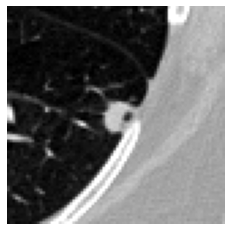

In [ ]:
sample = 'p0925_n00_m1.npy' # patient + nodule + model

xai_path = my_path + 'explanations/'
slice_path = my_path + 'slices/'
xai_methods = ['Saliency_Maps/', 'Integrated_Gradients/', 'LRP/', 'Deep_Lift/']
grids = ['4x4/','8x8/','16x16/','80x80/']

img = np.load(slice_path + sample)
plt.imshow(img, cmap='gray')
plt.axis('off')

/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Saliency_Maps/4x4/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Saliency_Maps/8x8/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Saliency_Maps/16x16/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Saliency_Maps/80x80/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Integrated_Gradients/4x4/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Integrated_Gradients/8x8/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Integrated_Gradients/16x16/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/Integrated_Gradients/80x80/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/LRP/4x4/
/content/gdrive/MyDrive/Paper_XAI/final_code&files/new_masks_29dec/explanations/LRP

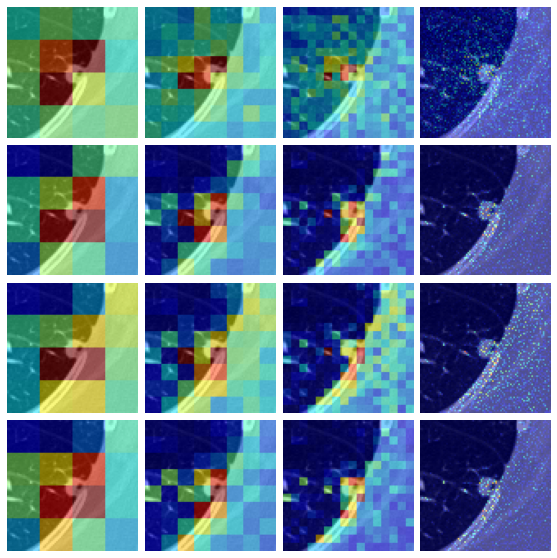

In [ ]:
masks = []
results = []

for method in xai_methods:
  for grid in grids:
    path = xai_path + method + grid
    mask = np.load(path + sample)
    result = get_mask_on_img(img, mask)
    results.append(result)
    ma = Image.fromarray(np.uint8(cm.jet(mask)*255))
    ma = np.array(ma)
    masks.append(ma)

fig = plt.figure(figsize=(10., 10.))
img_grid = ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.1)
for ax, im in zip(img_grid, results):
      # Iterating over the grid returns the Axes.
      ax.imshow(im)
      ax.axis('off')
plt.show()

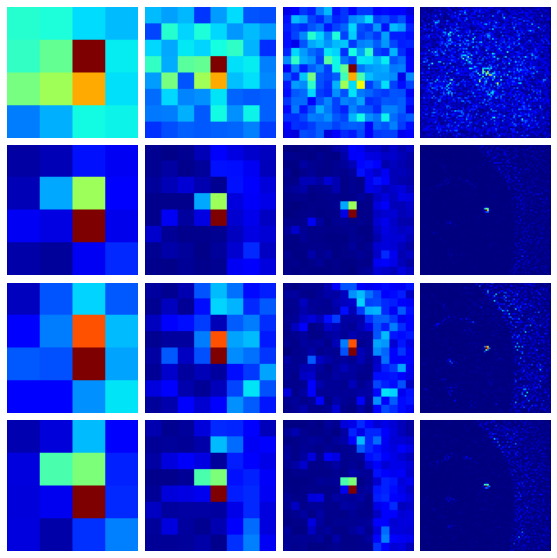

In [ ]:
fig = plt.figure(figsize=(10., 10.))
img_grid = ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.1)
for ax, im in zip(img_grid, masks):
      ax.imshow(im)
      ax.axis('off')
plt.show()